In [ ]:
!git clone https://github.com/sathishkumar67/Face-Recognition-using-Resnet.git
!mv /kaggle/working/Face-Recognition-using-Resnet/* /kaggle/working/
!pip install -r requirements.txt
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.5 MB/s eta 0:00:00


In [6]:
import os
import random
import shutil
import cv2
from PIL import Image
from collections import defaultdict
from mtcnn import MTCNN
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from huggingface_hub import hf_hub_download
from siamese_resnet import unzip_file
import torchvision.transforms as transforms

2025-05-03 05:22:23.822050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746249743.848197     759 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746249743.855772     759 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
DATASET_REPO_ID = "pt-sk/Face_Recognition_Dataset"
DATASET_FILENAME_IN_REPO = "Face Recognition Dataset.zip"
DATASET_REPO_TYPE = "dataset"
LOCAL_DIR = os.getcwd()

In [8]:
# Download the dataset from Hugging Face Hub
hf_hub_download(repo_id=DATASET_REPO_ID, filename=DATASET_FILENAME_IN_REPO, repo_type=DATASET_REPO_TYPE, local_dir=LOCAL_DIR)

# Unzip the dataset
unzip_file(os.path.join(LOCAL_DIR, DATASET_FILENAME_IN_REPO), LOCAL_DIR)

Face%20Recognition%20Dataset.zip:   0%|          | 0.00/5.10G [00:00<?, ?B/s]

Unzipping: 100%|██████████| 5.20G/5.20G [00:43<00:00, 120MB/s] 


Unzipped /kaggle/working/Face Recognition Dataset.zip to /kaggle/working
Removed zip file: /kaggle/working/Face Recognition Dataset.zip


In [9]:
# triplet loss function
# This function computes the triplet loss for a batch of anchor, positive, and negative samples.
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute pairwise distances
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        
        # Calculate triplet loss
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [10]:
class SiameseResNet(nn.Module):
    def __init__(self, embedding_dim=256):
        super(SiameseResNet, self).__init__()
        # Load pretrained ResNet18
        self.backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1", progress=True)
        
        # Replace the final fully connected layer
        self.backbone.fc = nn.Linear(512, embedding_dim)  # 512 -> 256

    def forward(self, x):
        return self.backbone(x)
    
    def print_parameters_count(self):
        total_params = sum(p.numel() for p in self.parameters()) / 1e6  # Convert to millions
        # Print the number of parameters in millions
        print(f"Total parameters: {total_params:.2f}m")

In [11]:
model = SiameseResNet(embedding_dim=256)
model.print_parameters_count()

Total parameters: 11.31m


In [12]:
# pass a sample image through the model
dummy_input = torch.randn(1, 3, 224, 224)  # batch size of 1, 3 channels, 224x224 image
output = model(dummy_input)
output.shape  # should be (1, 256) since we changed the final layer to output 256 features

torch.Size([1, 256])

In [13]:
def split_dataset(root_dir, save_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    # Ensure ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1.0
    
    # instantiate MTCNN for face detection
    detector = MTCNN()
    
    # Create split directories
    splits = ["train", "val", "test"]
    for split in splits:
        os.makedirs(f"{split}", exist_ok=True)
    
    # Get all identities with ≥1 image
    identities = [identity for identity in os.listdir(root_dir) 
                if os.path.isdir(os.path.join(root_dir, identity))]
    
    # Shuffle identities to ensure randomness
    random.shuffle(identities)
    
    # Split identities (not images!)
    total = len(identities)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)
    
    train_ids = identities[:train_end]
    val_ids = identities[train_end:val_end]
    test_ids = identities[val_end:]
    
    # Move all images of each identity to their split directory
    for split, ids in zip(splits, [train_ids, val_ids, test_ids]):
        items = []
        for identity in ids:
            # Get all images of the identity
            identity_dir = os.path.join(root_dir, identity)
            images = [os.path.join(identity_dir, img) for img in os.listdir(identity_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]
            for image in images:
                # convert to RGB
                img_array = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
                # Detect faces in the image
                faces = detector.detect_faces(img_array)
                if len(faces) >= 1:
                    # select the face with the highest confidence score
                    x, y, w, h = max(faces, key=lambda x: x['confidence'])["box"]
                    # crop the face from the image and resize it to 224x224
                    img_array = cv2.resize(img_array[y:y+h, x:x+w], (224, 224), interpolation=cv2.INTER_LANCZOS4)
                    # save the cropped image to the items list
                    items.append(img_array)
                else:
                    # If no face is detected, skip this image
                    print(f"No face detected in {identity}. Skipping...")
                    continue
        # stack the images in the items list
        items = np.stack(items, axis=0)
        # save the stacked images in the save directory
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, f"{split}.npy"), items)
    shutil.rmtree(root_dir)  # Remove the original dataset directory
    print("Original dataset directory removed.")

In [14]:
# split_dataset("Face Recognition Dataset", "arrays", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

In [ ]:
class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, num_triplets=10000):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.id_to_images = defaultdict(list)
        
        # Load identities and images for this split
        for identity in os.listdir(self.root_dir):
            identity_dir = os.path.join(self.root_dir, identity)
            if os.path.isdir(identity_dir):
                images = [os.path.join(identity_dir, img) 
                        for img in os.listdir(identity_dir) 
                        if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
                if len(images) >= 2:  # Only include identities with ≥2 images
                    self.id_to_images[identity] = images
        
        self.identities = list(self.id_to_images.keys())
        self.num_triplets = num_triplets
        
        # Precompute triplets for val/test for consistency
        if split in ['val', 'test']:
            self.triplets = self._precompute_triplets()

    def _precompute_triplets(self):
        """Generate fixed triplets for reproducible evaluation"""
        triplets = []
        for _ in range(self.num_triplets):
            # Anchor and positive from same identity
            anchor_id = random.choice(self.identities)
            anchor, positive = random.sample(self.id_to_images[anchor_id], 2)
            
            # Negative from different identity
            negative_id = random.choice(self.identities)
            while negative_id == anchor_id:
                negative_id = random.choice(self.identities)
            negative = random.choice(self.id_to_images[negative_id])
            
            triplets.append((anchor, positive, negative))
        return triplets

    def __len__(self):
        return self.num_triplets

    def __getitem__(self, idx):
        if hasattr(self, 'triplets'):  # Use precomputed for val/test
            anchor_path, pos_path, neg_path = self.triplets[idx]
        else:  # Dynamic generation for training
            anchor_id = random.choice(self.identities)
            anchor_path, pos_path = random.sample(self.id_to_images[anchor_id], 2)
            
            neg_id = random.choice(self.identities)
            while neg_id == anchor_id:
                neg_id = random.choice(self.identities)
            neg_path = random.choice(self.id_to_images[neg_id])
        
        # Load and transform images
        anchor = self._load_image(anchor_path)
        positive = self._load_image(pos_path)
        negative = self._load_image(neg_path)
        
        return anchor, positive, negative

    def _load_image(self, path):
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img

In [151]:
train_data = TripletFaceDataset(
    root_dir="splits",
    split="train",
    transform=None,
    num_triplets=50000  # Large number for training diversity
)

In [160]:
faces

[{'box': [17, 0, 153, 182],
  'confidence': 0.9959285855293274,
  'keypoints': {'nose': [90, 116],
   'mouth_right': [128, 137],
   'right_eye': [126, 64],
   'left_eye': [56, 65],
   'mouth_left': [58, 138]}}]

(-0.5, 152.5, 181.5, -0.5)

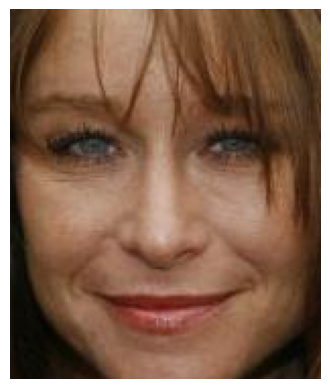

In [161]:
plt.imshow(a)
plt.axis('off')

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Define transforms
transform = transforms.Compose([
    transforms.Resize(100),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize dataset and dataloader
dataset = TripletFaceDataset(root_dir="path/to/dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, loss, and optimizer
model = SiameseResNet(embedding_dim=256)
criterion = TripletLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):
    for batch in dataloader:
        anchor, positive, negative = batch
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        # Forward pass
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)
        
        # Compute loss
        loss = criterion(anchor_emb, positive_emb, negative_emb)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")